# Transfer Learning in RUL Estimation
## Settings

In [ ]:
## Import libraries in python
import argparse
import time
import json
import logging
import sys
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from itertools import repeat
from scipy.stats import randint, expon, uniform

import tensorflow as tf
import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
import cv2
import io
from PIL import Image
from numba import jit, cuda



# Ignore tf err log
pd.options.mode.chained_assignment = None  # default='warn'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

# random seed predictable
seed = 0
random.seed(seed)
np.random.seed(seed)

# Setting Colab 
run_drive = True
if (run_drive == True):
  from google.colab import drive
  drive.mount('/content/drive')
  current_dir = './drive/MyDrive/Internship'
else:
  # Path settings
  current_dir = '.'#os.path.dirname(os.path.abspath(__file__))

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path = current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]

## temporary model path for NN
model_path = current_dir +'/temp_net.h5'

# Sensors not to be considered (those that do not disclose any pattern in their ts)
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

#start = time.time()

# Architecture preferences
dp = FD_path[1]
subdataset = dp_str[1]
sequence_length = 32
thres_type = None
thres_value = 50
device = 'cpu'
method = 'rps'
epochs = 1000
batch = 500
verbose = 1
flatten = False
visualize = False



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Network

In [ ]:
import time
import json
import logging as log
import sys
import datetime

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt
# import keras
import tensorflow as tf
print(tf.__version__)

# import keras.backend as K
import tensorflow.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

np.random.seed(0)
tf.random.set_seed(0)


def gen_net(model_name, weights, freeze):
    '''
    TODO: Implement other cnn model
    Todo: Freezing only few layers (read papers)
    :param model_name: vgg, inception
    :param weights: True/False
    :param pretrain: True/False
    :return:
    '''
    
    if (model_name == "vgg"):
        if (weights == True):
            model = VGG16(
                input_shape=(128,128,3), 
                weights = 'imagenet', 
                include_top = False)
        else:
            model = VGG16(
                input_shape=(128,128,3), 
                weights = None, 
                include_top = False)
    
    if (model_name == "inception"):
        if (weights == True):
            model = InceptionV3(
                input_shape=(128,128,3), 
                weights = 'imagenet', 
                include_top = False)
        else:
            model = InceptionV3(
                input_shape=(128,128,3),
                weights = None, 
                include_top = False)

    # This section has to be modified in order a pre defined number of layers
    if (freeze):
        for layer in model.layers[4:]:
            layer.trainable = False

    
    base_outputs = model.output
    flatten_outputs = Flatten()(base_outputs)
    final_outputs = Dense(1)(flatten_outputs)
    new_model = Model(inputs = model.input, outputs = final_outputs) 
    new_model.summary()

    # Make sure you have frozen the correct layers
    for i, layer in enumerate(new_model.layers):
        print(i, layer.name, layer.trainable)

    return new_model


# def gen_net(vec_len, num_hidden1, num_hidden2 ):
#     '''
#     TODO: Generate and evaluate any CNN instead of MLPs
#     :param vec_len:
#     :param num_hidden1:
#     :param num_hidden2:
#     :return:
#     '''

#     model = Sequential()
#     model.add(Dense(num_hidden1, activation='relu', input_shape=(vec_len,)))
#     model.add(Dense(num_hidden2, activation='relu'))
#     model.add(Dense(1))

#     return model

class network_fit(object):
    '''
    class for network
    '''

    def __init__(self, train_samples, label_array_train, test_samples, label_array_test,
                 model_path, model_name, weights, freeze, verbose=1):
        '''
        Constructor
        Generate a CNN and train
        @param none
        '''
        # self.__logger = logging.getLogger('data preparation for using it as the network input')
        self.train_samples = train_samples
        self.label_array_train = label_array_train
        self.test_samples = test_samples
        self.label_array_test = label_array_test
        self.model_path = model_path
        self.verbose = verbose

        # self.mlps = gen_net(self.train_samples.shape[1], self.n_hidden1, self.n_hidden2)
        self.mlps = gen_net(model_name, weights, freeze)



    def train_net(self, epochs, batch_size, lr= 1e-05, plotting=False):
        '''
        specify the optimizers and train the network
        :param epochs:
        :param batch_size:
        :param lr:
        :return:
        '''
        print("Initializing network...")
        # compile the model
        rp = optimizers.RMSprop(learning_rate=lr, rho=0.9, centered=True)
        adm = optimizers.Adam(learning_rate=lr, epsilon=1)
        sgd_m = optimizers.SGD(learning_rate=lr)

        keras_rmse = tf.keras.metrics.RootMeanSquaredError()
        self.mlps.compile(loss='mean_squared_error', optimizer=adm, metrics=[keras_rmse, 'mae'])
        
        log_dir = current_dir + "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        print(self.mlps.summary())

        # Train the model
        history = self.mlps.fit(self.train_samples, self.label_array_train, epochs=epochs, batch_size=batch_size,
                                validation_split=0.2, verbose=self.verbose,
                                callbacks=[
                                    tensorboard_callback,
                                    #TensorBoard(log_dir=log_dir, histogram_freq=1),
                                    EarlyStopping(monitor='val_root_mean_squared_error', 
                                                  min_delta=0, 
                                                  patience=50, 
                                                  verbose=self.verbose, 
                                                  mode='min'),
                                    ModelCheckpoint(self.model_path, 
                                                    monitor='val_root_mean_squared_error', 
                                                    save_best_only=True, 
                                                    mode='min',
                                                   verbose=self.verbose)])

        val_rmse_k = history.history['val_root_mean_squared_error']
        val_rmse_min = min(val_rmse_k)
        min_val_rmse_idx = val_rmse_k.index(min(val_rmse_k))
        stop_epoch = min_val_rmse_idx +1
        val_rmse_min = round(val_rmse_min, 4)
        print ("val_rmse_min: ", val_rmse_min)

        trained_net = self.mlps

        ## Plot training & validation loss about epochs
        if plotting == True:
            # summarize history for Loss
            fig_acc = plt.figure(figsize=(10, 10))
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.ylim(0, 2000)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()


        return trained_net



    def test_net(self, trained_net=None, best_model=True, plotting=True):
        '''
        Evalute the trained network on test set
        :param trained_net:
        :param best_model:
        :param plotting:
        :return:
        '''
        # Load the trained model
        if best_model:
            estimator = load_model(self.model_path)
        else:
            estimator = load_model(trained_net)

        # predict the RUL
        y_pred_test = estimator.predict(self.test_samples)
        y_true_test = self.label_array_test # ground truth of test samples

        pd.set_option('display.max_rows', 1000)
        test_print = pd.DataFrame()
        test_print['y_pred'] = y_pred_test.flatten()
        test_print['y_truth'] = y_true_test.flatten()
        test_print['diff'] = abs(y_pred_test.flatten() - y_true_test.flatten())
        test_print['diff(ratio)'] = abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()
        test_print['diff(%)'] = (abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()) * 100

        y_predicted = test_print['y_pred']
        y_actual = test_print['y_truth']
        rms = sqrt(mean_squared_error(y_actual, y_predicted)) # RMSE metric
        test_print['rmse'] = rms
        print(test_print)


        # Score metric
        h_array = y_predicted - y_actual
        s_array = np.zeros(len(h_array))
        for j, h_j in enumerate(h_array):
            if h_j < 0:
                s_array[j] = math.exp(-(h_j / 13)) - 1

            else:
                s_array[j] = math.exp(h_j / 10) - 1
        score = np.sum(s_array)

        # Plot the results of RUL prediction
        if plotting == True:
            fig_verify = plt.figure(figsize=(12, 6))
            plt.plot(y_pred_test, color="blue")
            plt.plot(y_true_test, color="green")
            plt.title('prediction')
            plt.ylabel('value')
            plt.xlabel('row')
            plt.legend(['predicted', 'actual data'], loc='upper left')
            plt.show()

        return rms, score

2.4.1


# VGG + NoWeights + No Freeze

In [ ]:
# Import training and test 
train_samples = np.load(current_dir +'/preprocess/train_samples.npy')
test_samples = np.load(current_dir +'/preprocess/test_samples.npy')
label_array_train = np.load(current_dir +'/preprocess/label_array_train.npy')
label_array_test = np.load(current_dir +'/preprocess/label_array_test.npy')

In [ ]:
# Creo l'oggetto net
mlps_net = network_fit(train_samples, 
                       label_array_train, 
                       test_samples, 
                       label_array_test,
                       model_path = model_path, 
                       model_name = "vgg",
                       weights = False,
                       freeze = False,
                       verbose=verbose)


In [ ]:
#Train
trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch)

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   122.854668     98.0  24.854668     0.253619   25.361904  17.194277
1    54.220322     69.0  14.779678     0.214198   21.419823  17.194277
2   104.537674     82.0  22.537674     0.274850   27.484968  17.194277
3   100.370895     91.0   9.370895     0.102977   10.297688  17.194277
4   107.347000     93.0  14.347000     0.154269   15.426882  17.194277
5   102.352783     91.0  11.352783     0.124756   12.475586  17.194277
6   110.680458     95.0  15.680458     0.165057   16.505745  17.194277
7   112.253510    111.0   1.253510     0.011293    1.129288  17.194277
8   108.473534     96.0  12.473534     0.129933   12.993264  17.194277
9    91.765678     97.0   5.234322     0.053962    5.396208  17.194277
10   96.250061    124.0  27.749939     0.223790   22.378983  17.194277
11   71.596230     95.0  23.403770     0.246355   24.635548  17.194277
12  128.145218    107.0  21.145218     0.197619   19.761887  17.194277
13   9

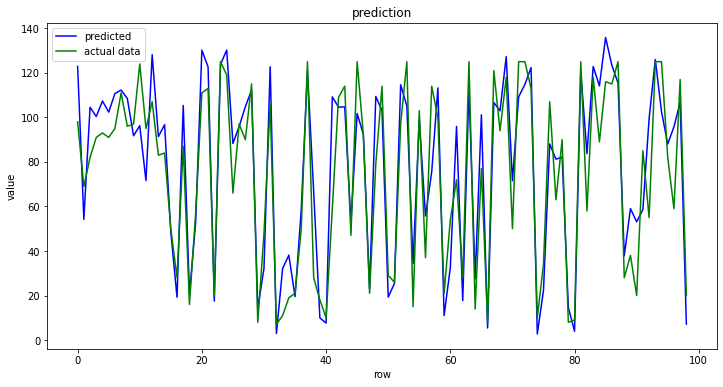

In [ ]:
# Test
rms, score = mlps_net.test_net(trained_net)

In [ ]:
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

FD001 test RMSE:  17.194276895495907
FD001 test Score:  648.0106614002016


In [ ]:
!tensorboard --logdir=logs

2021-05-09 19:20:37.173976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)


# Freezing some Layers
Il primo test verrá condotto sul freezing dei primi convolutional layers poiché sono quelli che posseggono 

In [ ]:
# Creo l'oggetto net
mlps_net = network_fit(train_samples, 
                       label_array_train, 
                       test_samples, 
                       label_array_test,
                       model_path = model_path, 
                       model_name = "vgg",
                       weights = True,
                       freeze = True,
                       verbose=verbose)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
#Train
trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch, plotting=True)

Initializing network...
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [ ]:
# Test
rms, score = mlps_net.test_net(trained_net)

In [ ]:
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)